<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Logistic Regression

_Authors: Kiefer Katovich (SF), Matt Brems (DC)_

---

### Learning Objectives
- Understand how logistic regression is similar to and different than regression.
- Understand the math behind the logit link function (and logistic function).
- Code the calculation of the odds ratio and log-odds ratio.
- Plot the logistic regression for predicting admittance from GPA.
- Understand how to interpret the coefficients of logistic regression.
- Know the benefits of logistic regression as a classifier.


### Lesson Guide
- [Introduction](#introduction)
- [Load the College Admissions Data](#load-data)
- [Regression Models Estimate the Expected Value of `y`](#expected-value)
- [What Happens if we Predict `admit` With `gpa` Using Linear Regression?](#pred-admit)
    - [Plot the Regression Line](#plot-reg)
- [Predicting a Binary Class](#pred-binary)
- [The Logit Link Function](#logit-link)
    - [Aside: Odds Ratios](#odds-ratios)
    - [Step 1: The Odds Ratio in Place of `y`](#odds-ratio-inplace)
    - [Step 2: The Log-Odds Ratio Instead of the Odds Ratio](#log-odds)
- [The Logistic Function](#logistic)
- [The Logistic Regression Prediction Line, Visually](#logistic-viz)
- [Solving for the Beta Coefficients](#solving-beta)
- [Interpreting Logistic Regression Coefficients](#interpreting)
- [Conclusion](#conclusion)
- [Additional Resources](#resources)

<a id='introduction'></a>

## Introduction

---

Logistic regression is a famous classifier that's still used frequently, despite its age. It _is_ a regression, but don't let that confuse you — it operates as a classifier. It estimates probabilities of class membership.

In this lecture, we'll only be reviewing the binary outcome case with two classes, but logistic regression can be generalized to multiple classes.

**Some examples of when logistic regression could be used:**
- To predict whether or not a user will purchase a product given their demographic characteristics.
- To predict the likelihood of a student being admitted to a college, given their scores and the characteristics of the college.
- To diagnose a patient as having a disease or not, given their symptoms.
- To predict whether or not a person will default on a loan and with what likelihood.

And many more. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm

/Users/edoardo/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Some colors we can use in our plots:
colors = {'blue': '#729ECE',
          'brown': '#A8786E',
          'green': '#67BF5C',
          'grey': '#A2A2A2',
          'orange': '#FF9E4A',
          'pink': '#ED97CA',
          'purple': '#AD8BC9',
          'red': '#ED665D',
          'teal': '#6DCCDA',
          'yellow': '#CDCC5D'}

<a id='load-data'></a>

## Load the College Admissions Data

---

As we walk through the inner workings of logistic regression, we'll be using some basic college admissions data. The data set only has a few columns:
- `admit`: A binary 1-0 variable indicating whether or not a student was admitted.
- `gre`: The student's GRE score.
- `gpa`: The student's GPA.
- `prestige`: A rating for the college's "prestige."

**Load in the data and perform any necessary cleaning.**

In [3]:
admissions = pd.read_csv('./datasets/admissions.csv')

In [4]:
admissions.head(3)

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0


In [5]:
admissions.isnull().sum()

admit       0
gre         2
gpa         2
prestige    1
dtype: int64

In [6]:
admissions.dropna(inplace=True)

### Artificially increase the signal in the data.

The signal for detecting admission in the college data is fairly weak — too weak for the purposes of our demonstration. Below, we not only multiply the data set by 10 but also add an artificial signal for detecting `admit` to the `gpa` column. 

*Obviously* you would never do this to your real data.

In [7]:
admit = admissions[admissions.prestige == 1]

admit = pd.concat([admit]*10, axis=0)

admit.loc[admit.admit == 1, 'gpa'] += np.random.random(size=admit[admit.admit == 1].shape[0])
admit.loc[admit.admit == 0, 'gpa'] -= np.random.random(size=admit[admit.admit == 0].shape[0])

*The addition of random signal will cause slight variance in our results throughout the lesson.*

<a id='expected-value'></a>

## Regression Models Estimate the Expected Value of `y`

---

Logistic regression is a regression. It still constructs a formula with our predictor variables and coefficients to estimate the *expected value* of the target variable.

You're quite familiar with linear regression. We've re-written the formula slightly on the left-hand side:

### $$E(y|X) = \beta_0 + \sum_{j}^p\beta_jx_j$$

Where:
- $E(y|X)$ is the Expected Value (Mean) of `y` Given Corresponding Predictor Values in Matrix `X`.
- $\sum_{j}^p$ are the predictors $j$ through $p$ (columns) of the $X$ matrix.
- $\beta_0$ is the intercept.
- $\beta_j$ is the coefficient for the predictor $x_j$, the $j$th column in variable matrix $X$.


<a id='pred-admit'></a>

## What If We Predicted `admit` With `gpa` Using Linear Regression?

---

Let's try predicting the `admit` binary indicator using just `gpa` with a linear regression to see what goes wrong.

In [8]:
y = admit.admit.values
X = admit[['gpa']].values

linmod = LinearRegression()
linmod.fit(X, y)

print 'Intercept:', linmod.intercept_
print 'Coef(s):', linmod.coef_

Intercept: -1.2625890359226282
Coef(s): [0.51557969]


/Users/edoardo/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


<a id='plot-reg'></a>
### What do those coefficients mean?  Plot `admit ~ gpa`.

How can we interpret these coefficients when we know that `admit` is either 0 or 1? Looking at the plot below, what's the apparent problem with using a regression?

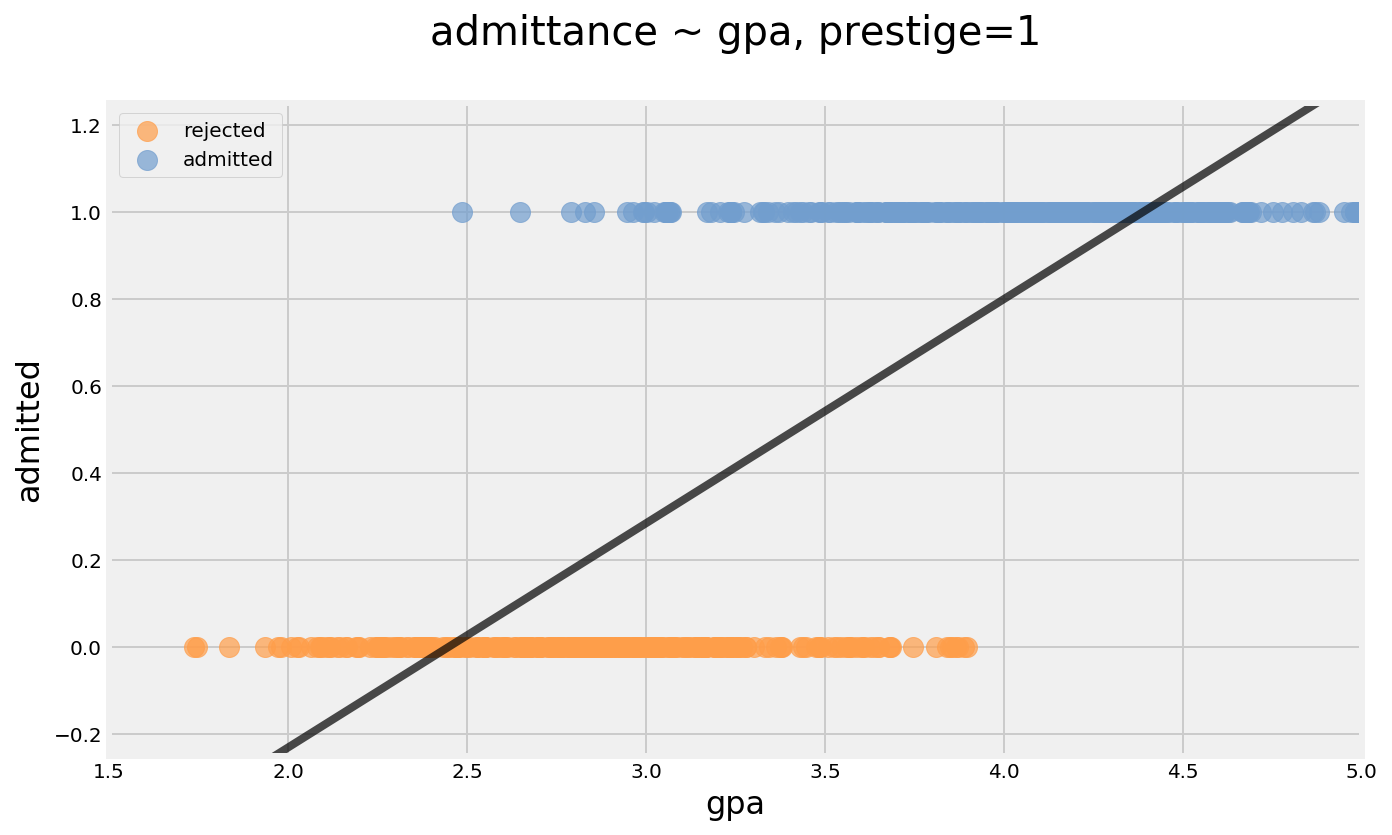

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
#fig.set_size_inches(6,5)

# Plot the regression line for admit ~ gpa.
x_vals = np.linspace(1.,5.,300)
ax.plot(x_vals, linmod.predict(x_vals[:, np.newaxis]),
        color='black', alpha=0.7, lw=4)

# Create one scatterplot for each type of wine.
ax.scatter(admit.gpa[admit.admit == 0],
           admit.admit[admit.admit == 0],
           c=colors['orange'], s=100, alpha=0.7,
           label='rejected')

ax.scatter(admit.gpa[admit.admit == 1],
           admit.admit[admit.admit == 1],
           c=colors['blue'], s=100, alpha=0.7,
           label='admitted')

ax.set_ylabel('admitted', fontsize=16)
ax.set_xlabel('gpa', fontsize=16)
ax.set_title('admittance ~ gpa, prestige=1\n', fontsize=20)

ax.set_xlim([1.5,5])
ax.set_ylim(-0.25, 1.25)

plt.legend(loc='upper left')
plt.show()

<a id='pred-binary'></a>

## Predicting a Binary Class

---

In our case we have two classes: `1=admitted` and `0=rejected`.

The logistic regression is still solving for an expected value. In our binary classification case, this expected value is the probability of `y` being one of the classes.

### $$E(y) = P(y = 1)$$

As you can see, we still represent this with a regression on the right-hand side.

### $$E(y|X) = P(y = 1|X) = \beta_0 + \sum_{j}^p\beta_jx_j$$

There's a clear problem with this, which we saw in the previous plot. The right side of the equation is in no way bounded to [0, 1]. We need to *guarantee* that the right-hand side of the regression equation will evaluate to a probability estimate.

<a id='logit'></a>

## The Logit Link Function

---

Logistic regression can still be solved by the minimization of the sum of squared errors, and there's still an intercept and coefficients.

How do we do this? In general, regressions can be generalized to $y$ targets that do not fall between `[-infinity, infinity]` through the use of **link functions**.

A link function is simply a function that we apply to both sides of the regression in order to constrain `y` to a desired range.

### $$\text{logit}(\;y\;) = \text{logit}(\; \beta_0 + \sum_{j}^p\beta_jx_j \;)$$


---
<a id='odds-ratios'></a>
### Aside: Odds Ratios

The initial step in the logit link function involves the use of **odds ratios**. Before we get into _why_, it's important to understand the definition of an odds ratio.

Probabilities and odds ratios represent the same thing in different ways. Probabilities can be alternatively expressed as odds ratios. The odds ratio for probability **p** is defined as:

### $$\text{odds ratio}(p) = \frac{p}{1-p}$$

The odds ratio of a probability is a measure of how many times more likely it is than the inverse case.

For example:

- When **`p = 0.5`**: **`odds ratio = 1`**
    - It's equally likely to happen as it is to not happen.
- When **`p = 0.75`**: **`odds ratio = 3`**
    - It's three times more likely to happen than to not happen.
- When **`p = 0.40`**: **`odds ratio = 0.666..`**
    - It's two-thirds as likely to happen than to not happen.

#### What are the probabilities of admittance by prestige?

In [10]:
admissions.prestige.unique()

array([3., 1., 4., 2.])

In [11]:
y_p1 = admissions[admissions.prestige == 1].admit.values
y_p2 = admissions[admissions.prestige == 2].admit.values
y_p3 = admissions[admissions.prestige == 3].admit.values
y_p4 = admissions[admissions.prestige == 4].admit.values

In [12]:
print 'P(admit | prestige = 1):', np.mean(y_p1)
print 'P(admit | prestige = 2):', np.mean(y_p2)
print 'P(admit | prestige = 3):', np.mean(y_p3)
print 'P(admit | prestige = 4):', np.mean(y_p4)

P(admit | prestige = 1): 0.540983606557
P(admit | prestige = 2): 0.358108108108
P(admit | prestige = 3): 0.231404958678
P(admit | prestige = 4): 0.179104477612


#### Write a function to calculate odds ratios, and calculate the odds ratios of admittance by prestige.

In [13]:
def odds_ratio(p):
    return (float(p) / (1 - p))

In [14]:
print 'odds(admit | prestige = 1):', odds_ratio(np.mean(y_p1))
print 'odds(admit | prestige = 2):', odds_ratio(np.mean(y_p2))
print 'odds(admit | prestige = 3):', odds_ratio(np.mean(y_p3))
print 'odds(admit | prestige = 4):', odds_ratio(np.mean(y_p4))

odds(admit | prestige = 1): 1.17857142857
odds(admit | prestige = 2): 0.557894736842
odds(admit | prestige = 3): 0.301075268817
odds(admit | prestige = 4): 0.218181818182


---
<a id='odds-ratio-inplace'></a>
### Step 1: The Odds Ratio in Place of `y`

We have two conditions to fulfill with the logit function:
1) Our estimate of `y` must represent a probability in some way.
2) The right-hand side regression formula (pre-transformation) must be able to evaluate to anything within the real number range.

Right now our estimate for `y` falls between 0 and 1. If we can transform this probability to something that is unbounded, then the right-hand side of the equation will work.

We can start by putting the odds ratio in place of the probability on the left side of the regression equation:

### $$ \frac{P(y = 1)}{1-P(y = 1)} = \beta_0 + \sum_{j}^p\beta_jx_j$$

The range of odds ratio — our predicted value — is now restricted to be in the range **`[0, infinity]`**


#### What happens if we just leave it like this?

In [17]:
def pred_to_odds(pred):
    return pred / (1. + pred)

def minimize_gpa_odds(betas):
    pred = betas[0] + betas[1]*X.ravel()
    odds_pred = pred_to_odds(pred)
    return np.sum((y - odds_pred)**2)
    

**The `scipy.optimize.minimize` function can optimize arbitrary functions:**

In [18]:
from scipy.optimize import minimize

min_betas = minimize(minimize_gpa_odds, np.array([0.,1.]))

In [19]:
min_betas.x

array([-2.22415862,  1.00175172])

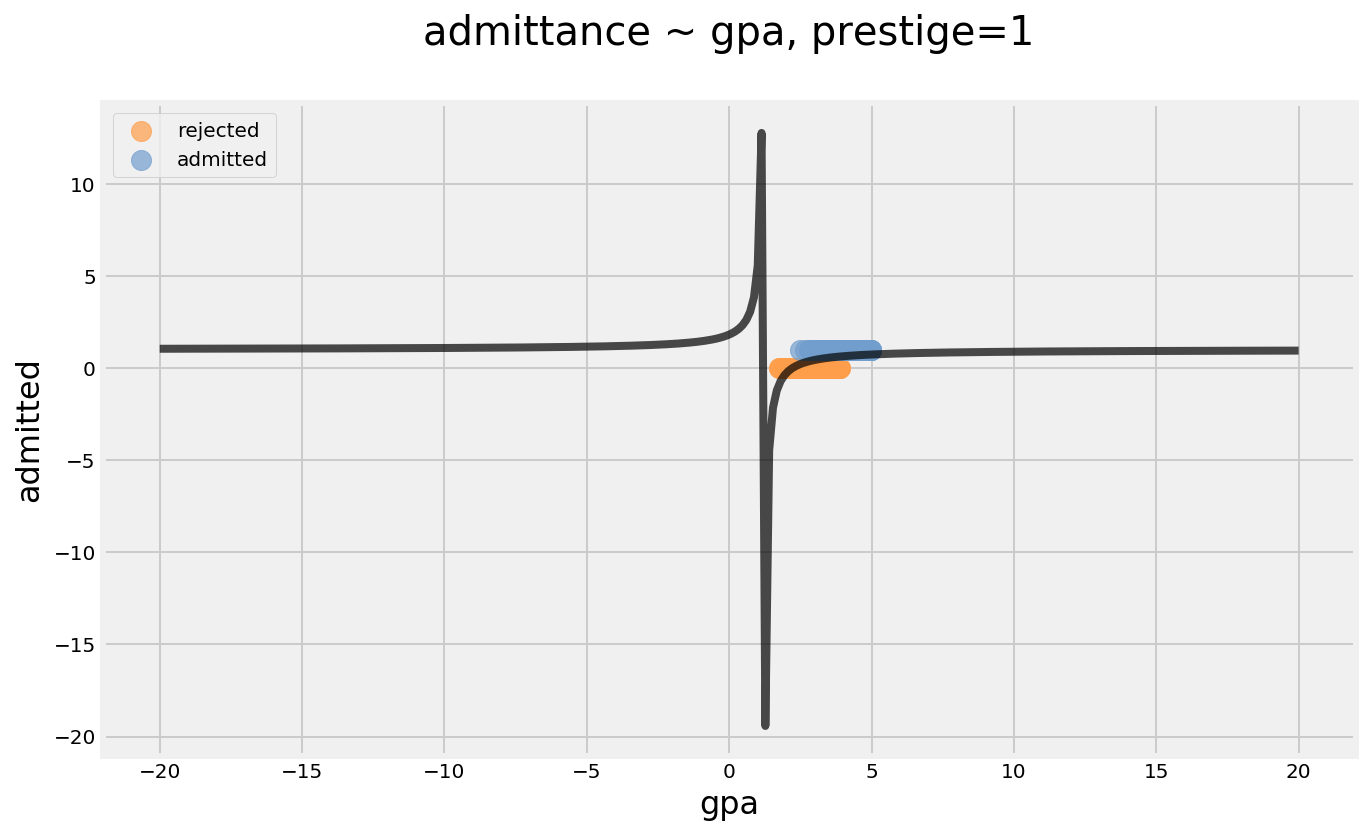

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
#fig.set_size_inches(6,5)

# Plot the regression line for admit ~ gpa.
x_vals = np.linspace(-20,20,300)
y_vals = min_betas.x[0] + min_betas.x[1]*x_vals
y_vals = pred_to_odds(y_vals)

ax.plot(x_vals, y_vals, color='black', alpha=0.7, lw=4)

# Create one scatterplot for each type of wine.
ax.scatter(admit.gpa[admit.admit == 0],
           admit.admit[admit.admit == 0],
           c=colors['orange'], s=100, alpha=0.7,
           label='rejected')

ax.scatter(admit.gpa[admit.admit == 1],
           admit.admit[admit.admit == 1],
           c=colors['blue'], s=100, alpha=0.7,
           label='admitted')

ax.set_ylabel('admitted', fontsize=16)
ax.set_xlabel('gpa', fontsize=16)
ax.set_title('admittance ~ gpa, prestige=1\n', fontsize=20)

#ax.set_xlim([0,20])
#ax.set_ylim([-.3, 3])

plt.legend(loc='upper left')
plt.show()

**Obviously the regression line isn't right.** But we can see that as GPA increases, we're asymptoting to 1.0 for our prediction.

<a id='log-odds'></a>

### Step 2: Using the log-odds —the natural logarithm of the odds ratio — instead of the odds ratio.

If we take the natural logarithm of a variable that falls between zero and infinity, we can transform it into a variable that falls between the range negative infinity and infinity.

This is because taking the logarithm of fractions results in negative numbers.

The formula now works — the regression can predict any negative or positive number, and we can convert it back into the odds ratio.

The combination of converting the probability to an odds ratio and taking the logarithm of that is called the **logit link function**:

### $$\text{logit}\big(y\big) = ln\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) =  \beta_0 + \sum_{j}^p\beta_jx_j$$

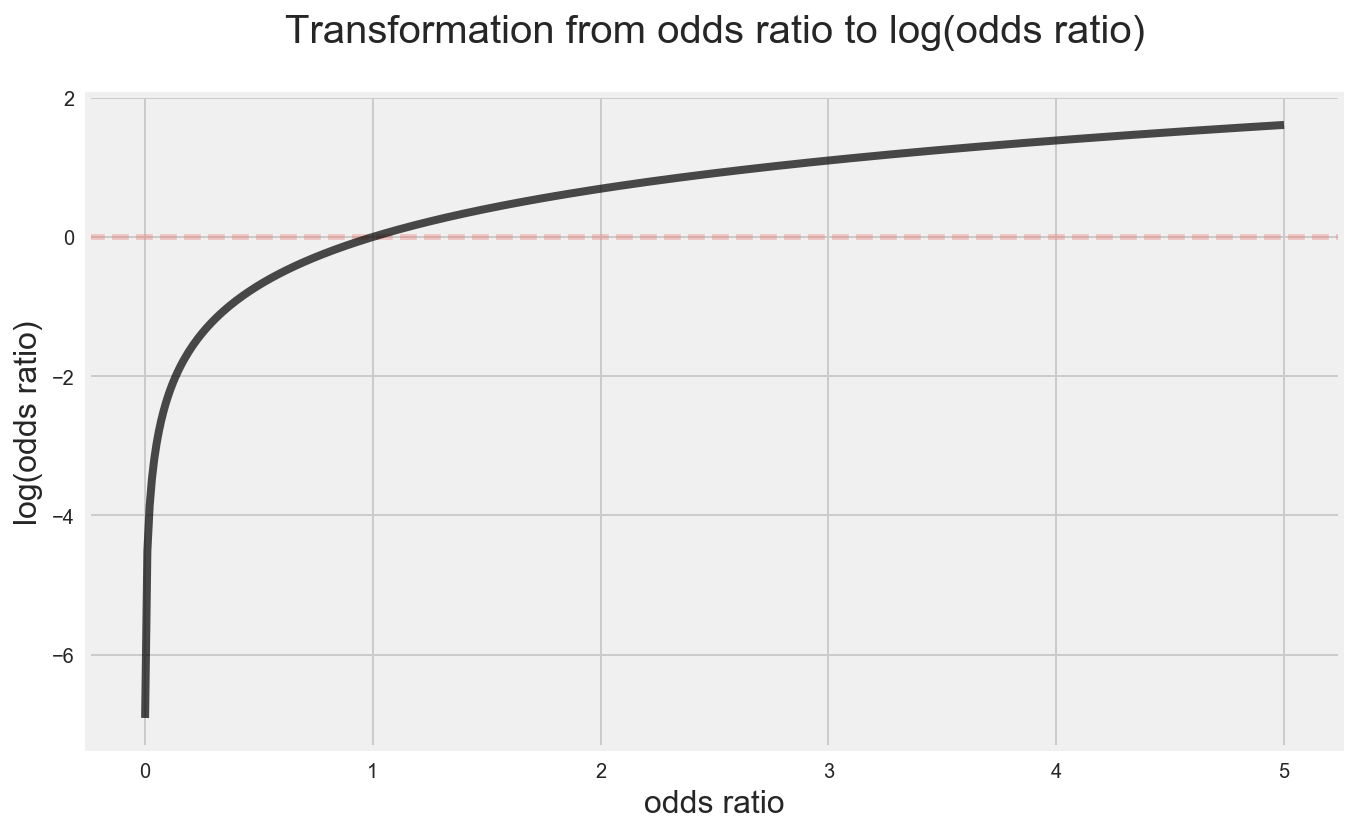

In [19]:
xs = np.linspace(0.001, 5, 500)
ys = np.log(xs)

plt.figure(figsize=[10,6])
plt.axhline(y=0, linewidth=3, c=colors['red'], ls='dashed', alpha=0.3)
plt.plot(xs, ys, lw=4, c='black', alpha=0.7)

plt.xlabel('odds ratio', fontsize=16)
plt.ylabel('log(odds ratio)', fontsize=16)
plt.title('Transformation from odds ratio to log(odds ratio)\n',fontsize=20)

<a id='logistic'></a>
## The Logistic Function

---

The inverse function of the logit is called the **logistic function**. 

By inverting the logit, we can have the right side of our regression equation solve explicitly for $P(y = 1)$:

### $$P(y=1) = logit^{-1}\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)$$

Where:

### $$logit^{-1}(a) = logistic(a) = \frac{e^{a}}{e^{a} + 1}$$ 

Giving us:

### $$P(y=1) = \frac{e^{\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)}}{e^{\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)}+1}$$

<a id='logistic-viz'></a>

## The Logistic Regression Prediction Line, Visually

---

Let's plot the prediction of `admit` using scikit-learn's `LogisticRegression` class and see what the regression line looks like.

In [31]:
y = admit.admit.values
X = admit[['gpa']].values

logreg = LogisticRegression()
logreg.fit(X, y)

print 'Logreg intercept:', logreg.intercept_
print 'Logreg coef(s):', logreg.coef_
print 'Logreg predicted probabilities:', logreg.predict_proba(X[0:5,:])

Logreg intercept: [-8.4595109]
Logreg coef(s): [[ 2.54403313]]
Logreg predicted probabilities: [[ 0.02153562  0.97846438]
 [ 0.42008986  0.57991014]
 [ 0.87179066  0.12820934]
 [ 0.04339439  0.95660561]
 [ 0.01400951  0.98599049]]


In [21]:
# 0 = b0 + b1x
# -b0 = b1x
# -b0/b1 = x

xval_chance = (-1 * logreg.intercept_[0])/logreg.coef_[0][0]
print xval_chance*logreg.coef_[0][0] + logreg.intercept_
print xval_chance

logreg.predict_proba([[xval_chance]])

[ 0.]
3.32523614487


array([[ 0.5,  0.5]])

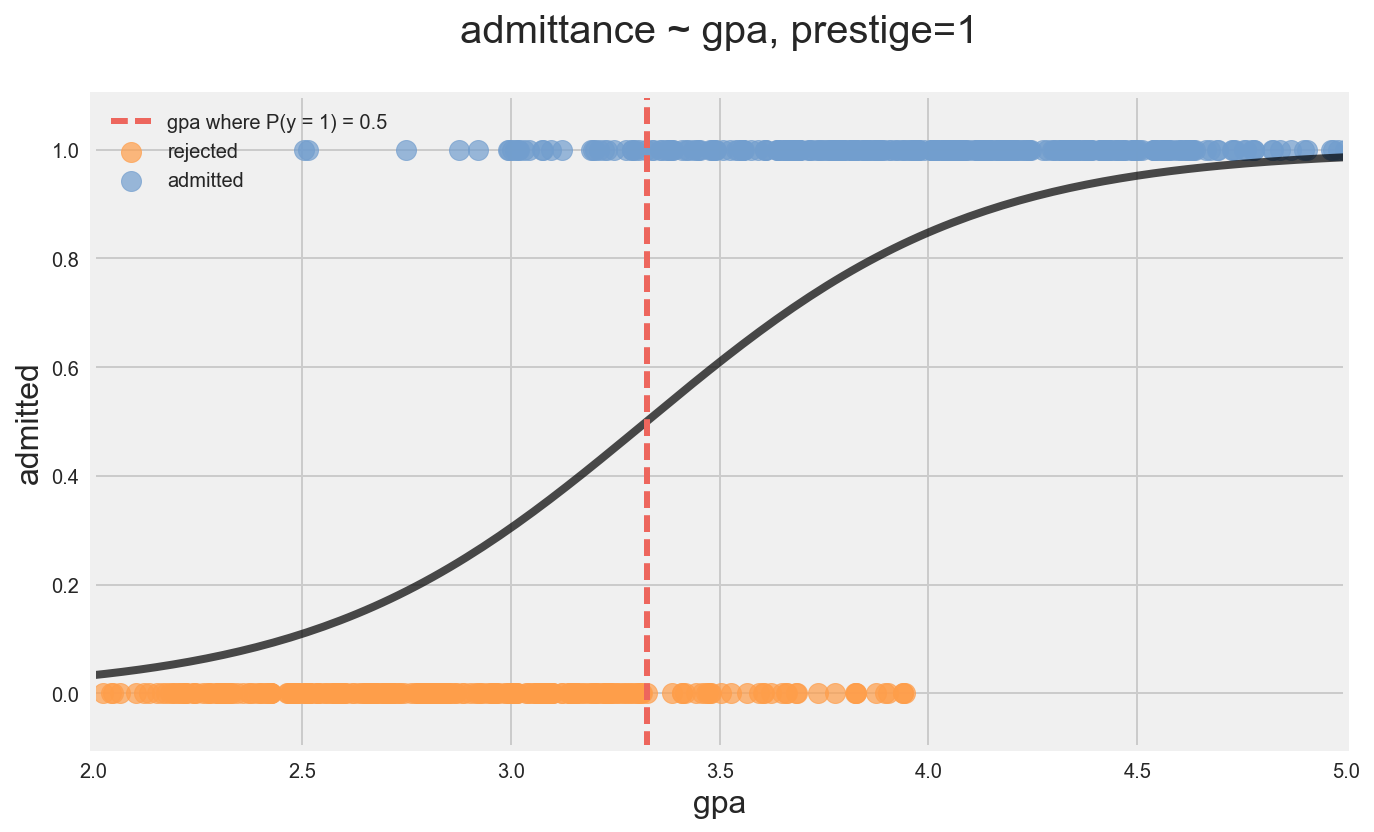

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot the logreg regression line for admit ~ gpa.
x_vals = np.linspace(-1.,5.,300)
y_pp = logreg.predict_proba(x_vals[:, np.newaxis])[:,1]

ax.plot(x_vals, y_pp, color='black', alpha=0.7, lw=4)

# Create one scatterplot for each type of wine.
ax.scatter(admit.gpa[admit.admit == 0],
           admit.admit[admit.admit == 0],
           c=colors['orange'], s=100, alpha=0.7,
           label='rejected')

ax.scatter(admit.gpa[admit.admit == 1],
           admit.admit[admit.admit == 1],
           c=colors['blue'], s=100, alpha=0.7,
           label='admitted')

ax.axvline(xval_chance, lw=3, color=colors['red'], ls='dashed',
           label='gpa where P(y = 1) = 0.5')

ax.set_ylabel('admitted', fontsize=16)
ax.set_xlabel('gpa', fontsize=16)
ax.set_title('admittance ~ gpa, prestige=1\n', fontsize=20)

ax.set_xlim([2.,5.])
ax.set_ylim([-0.1, 1.1])

plt.legend(loc='upper left')
plt.show()

<a id='solving-beta'></a>
## Solving For the Beta Coefficients

---

Logistic regression minimizes the "deviance," which is similar to the residual sum of squares in linear regression. There's no closed-form solution to the beta coefficients like in linear regression, and the betas are found through optimization procedures.

If you're particularly interested in the math, here are two helpful resources:

[A good blog post](http://www.win-vector.com/blog/2011/09/the-simpler-derivation-of-logistic-regression/) on the logistic regression beta coefficient derivation.

[This paper](https://www.stat.cmu.edu/~cshalizi/402/lectures/14-logistic-regression/lecture-14.pdf) is also a good reference.

<a id='interpreting'></a>

## Interpreting Logistic Regression Coefficients

---

The interpretation of logistic regression coefficients can be a little confusing because of the logistic function.

**To make it easier, start by centering your predictor variables (i.e., subtracting the mean).**

In [23]:
Xc = X - X.mean()
print Xc[0:5, :]

[[ 1.35600212]
 [-0.01735713]
 [-0.89756951]
 [ 1.07172324]
 [ 1.52802583]]


#### Why does centering matter?

Centering helps greatly because it makes the "baseline" for the predictor — the value at 0 — the same as the mean of the predictor. So, in our case, when `gpa = 0`, this is the average `gpa` across students.

After re-running the regression, we can take a look at the coefficients.

In [24]:
# use our centered GPA values to fit for Admittance
logreg = LogisticRegression()
logreg.fit(Xc, y)

print 'Logreg intercept:', logreg.intercept_
print 'Logreg coef(s):', logreg.coef_

Logreg intercept: [ 0.3924184]
Logreg coef(s): [[ 4.18684011]]


#### The meaning of the betas in log-odds.

Remember that our values are presented in terms of log-odds. 

> If $\beta_1$ is 0, then $\beta_0$ represents the log-odds of admittance for a student with an average GPA.

> $\beta_1$ is the effect of a unit increase in GPA on the log-odds of admittance. 

Log-odds can be hard to interpret. Luckily, we can apply the logistic transform to get the probability of admittance at different $\beta$ values.

In [25]:
def logistic_transformation(gpa, b0, b1):
    regression_sum = b0 + b1*gpa
    exponentiated = np.exp(regression_sum)
    return exponentiated / (1 + exponentiated)
    

The probability of admittance with an average GPA:

In [26]:
print 'average gpa:', np.mean(X[:,0])
print 'P(admitted | average gpa = 3.5):', logistic_transformation(0, logreg.intercept_[0], logreg.coef_[0][0])

average gpa: 3.46932296645
P(admitted | average gpa = 3.5): 0.596864744023


In [27]:
# Probability of admissions with a below average gpa (~3.0)
logistic_transformation(-.5, logreg.intercept_[0], logreg.coef_[0][0])

0.15433448829699697

In [28]:
# 2.5 = mean_gpa + x
# 2.5 - mean_gpa = x
print 'gpa = 2.5, difference from mean:', 2.5 - np.mean(X[:,0])
print 'P(admitted | gpa = 2.5):', logistic_transformation(2.5 - np.mean(X[:,0]), 
                                                          logreg.intercept_[0], logreg.coef_[0][0])

gpa = 2.5, difference from mean: -0.96932296645
P(admitted | gpa = 2.5): 0.024941074624


In [29]:
# 4 = mean_gpa + x
# 4 - mean_gpa = x
print 'gpa = 4, difference from mean:', 4 - np.mean(X[:,0])
print 'P(admitted | gpa = 4):', logistic_transformation(4. - np.mean(X[:,0]), 
                                                        logreg.intercept_[0], logreg.coef_[0][0])

gpa = 4, difference from mean: 0.53067703355
P(admitted | gpa = 4): 0.931774872094


** With more coefficients, setting $\beta$ values other than the value of interest to zero — except the intercept — will let you see the change in probability as the corresponding $x$ variable changes.**

In [30]:
# lets check our results against SKLearns
i = 4.0
i = i-X.mean() # scale around a mean of 0
print logreg.predict(i) # boolean classification

# probabilities associated with each possible outcome
print logreg.predict_proba(i) 

[1]
[[ 0.06822513  0.93177487]]


*In Sklearn's Logistic Regression the default probability to determine if an observation belongs or does not belong in a class is 50%.  Using the `.predict_proba()` method we can get the probabilities for both classes of admittance possibilities.  First value is class `0`, second is class `1`. We can see that the probability for class `1` is eactly the result from our logistic tranformation.*

<a id='conclusion'></a>

## Conclusion

---

The goal of logistic regression is to find the best-fitting model to describe the relationship between the characteristic of interest (dependent variable = response or outcome variable) and a set of independent (predictor or explanatory) variables. 

Logistic regression generates the coefficients — and in statsmodels the standard errors and significance levels — of a formula to predict a logit transformation of the probability that the characteristic of interest is present.

**Benefits of logistic regression include:**
- It's a classification algorithm that shares similar properties to linear regression.
- It's efficient and is by far the most common classification algorithm.
- The coefficients in a logistic regression model are interpretable (albeit somewhat complex); they represent the change in log-odds caused by the input variables.

<a id='resources'></a>

## Additional Resources

---

- [Logistic Regression Video Walk Through](https://www.youtube.com/watch?v=zAULhNrnuL4&noredirect=1)
- [Logistic Regression Walk Through](http://www.mc.vanderbilt.edu/gcrc/workshop_files/2004-11-12.pdf)
- [Logistic Regression w/ Statsmodel - Well Switching in Bangladesh](http://nbviewer.ipython.org/urls/raw.github.com/carljv/Will_it_Python/master/ARM/ch5/arsenic_wells_switching.ipynb)
- [Odds Ratio Explanation](http://www.wright.edu/~thaddeus.tarpey/ES714glm.pdf)
- [0 and 1 are not Probabilities](http://lesswrong.com/lw/mp/0_and_1_are_not_probabilities/)